Exploring a graph.

In [2]:
import requests, readline, sys, json
import numpy
import networkx as nx
import matplotlib as mpl
%matplotlib inline
%config InlineBacked.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn
from graphviz import Digraph

from query import *
from summary import *


vertexQ is a query to get all vertex labels:

In [3]:
vertexQ

'g.V().label().groupCount()'

getQuery gets the query results, and printResp prints a response

In [4]:
printResp(getQuery(vertexQ))


Response: 200
{'Event': '2128592', 'FileObject': '119413', 'SrcSinkObject': '19566', 'Principal': '10', 'Subject': '23225', 'NetFlowObject': '36'}


getGroupCountQuery runs a query and converts the resulting dictionary to a groupCount

In [5]:
getGroupCountQuery(vertexQ)

Response: 200


[{'Event': 2128592,
  'FileObject': 119413,
  'NetFlowObject': 36,
  'Principal': 10,
  'SrcSinkObject': 19566,
  'Subject': 23225}]

getVertices collects the counts and number of incoming and outgoing edge labels for each vertex label.  For example:

In [6]:
vertices = getVertexSummary()
print (vertices)

Response: 200
Vertex types/counts:
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
{'Event': {'count': 2128592, 'in': {}, 'out': {'predicateObject2': 248520, 'subject': 2128592, 'predicateObject': 2062524}}, 'FileObject': {'count': 119413, 'in': {'predicateObject2': 238699, 'predicateObject': 1746127}, 'out': {}}, 'SrcSinkObject': {'count': 19566, 'in': {'predicateObject2': 9783, 'predicateObject': 62754}, 'out': {}}, 'Principal': {'count': 10, 'in': {'localPrincipal': 23223}, 'out': {}}, 'Subject': {'count': 23225, 'in': {'parentSubject': 23069, 'subject': 2128592, 'predicateObject': 253475}, 'out': {'localPrincipal': 23223, 'parentSubject': 23069}}, 'NetFlowObject': {'count': 36, 'in': {'predicateObject2': 38, 'predicateObject': 168}, 'out': {}}}


Likewise, getEdges collects the counts of edge labels and the number of vertex labels on the source and target of each edge.

In [7]:
edges = getEdgeSummary()
print (edges)

Response: 200
Edge types/counts:
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
{'predicateObject2': {'count': 248520, 'in': {'FileObject': 238699, 'SrcSinkObject': 9783, 'NetFlowObject': 38}, 'out': {'Event': 248520}}, 'localPrincipal': {'count': 23223, 'in': {'Principal': 23223}, 'out': {'Subject': 23223}}, 'parentSubject': {'count': 23069, 'in': {'Subject': 23069}, 'out': {'Subject': 23069}}, 'subject': {'count': 2128592, 'in': {'Subject': 2128592}, 'out': {'Event': 2128592}}, 'predicateObject': {'count': 2062524, 'in': {'FileObject': 1746127, 'SrcSinkObject': 62754, 'Subject': 253475, 'NetFlowObject': 168}, 'out': {'Event': 2062524}}}


Hmm.  Not very readable.  Let's try to do better.  printSummary takes a dictionary in one of the above forms and prints out the results in a more structured way.

In [8]:
printSummary(vertices)

{}
 -> 
Event[2128592]
 -> 
{predicateObject2[248520],
subject[2128592],
predicateObject[2062524]}

{predicateObject2[238699],
predicateObject[1746127]}
 -> 
FileObject[119413]
 -> 
{}

{predicateObject2[9783],
predicateObject[62754]}
 -> 
SrcSinkObject[19566]
 -> 
{}

{localPrincipal[23223]}
 -> 
Principal[10]
 -> 
{}

{parentSubject[23069],
subject[2128592],
predicateObject[253475]}
 -> 
Subject[23225]
 -> 
{localPrincipal[23223],
parentSubject[23069]}

{predicateObject2[38],
predicateObject[168]}
 -> 
NetFlowObject[36]
 -> 
{}



How about for edges?

In [9]:
printSummary(edges)

{FileObject[238699],
SrcSinkObject[9783],
NetFlowObject[38]}
 -> 
predicateObject2[248520]
 -> 
{Event[248520]}

{Principal[23223]}
 -> 
localPrincipal[23223]
 -> 
{Subject[23223]}

{Subject[23069]}
 -> 
parentSubject[23069]
 -> 
{Subject[23069]}

{Subject[2128592]}
 -> 
subject[2128592]
 -> 
{Event[2128592]}

{FileObject[1746127],
SrcSinkObject[62754],
Subject[253475],
NetFlowObject[168]}
 -> 
predicateObject[2062524]
 -> 
{Event[2062524]}



Now let's build and visualize a (bipartite) graph.  Nodes will represent either node or edge labels, and edges represent that a node can have an in-edge or out-edge with a given label (or vice versa).

In [10]:
G = nx.DiGraph()


In [11]:
G.add_nodes_from(vertices,bipartite=0)
G.add_nodes_from(edges,bipartite=1)

In [12]:
for v in vertices.keys():
    for e in vertices[v]['in'].keys():
        G.add_edge(e,v)
    for e in vertices[v]['out'].keys():
        G.add_edge(v,e)

In [13]:
nx.is_bipartite(G)

True

In [14]:
from networkx.algorithms import bipartite
bottom_nodes, top_nodes = bipartite.sets(G)
bottom_nodes,top_nodes

({'Event',
  'FileObject',
  'NetFlowObject',
  'Principal',
  'SrcSinkObject',
  'Subject'},
 {'localPrincipal',
  'parentSubject',
  'predicateObject',
  'predicateObject2',
  'subject'})

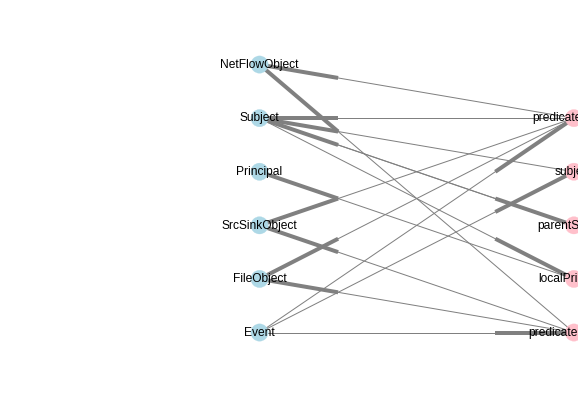

In [15]:
def showBiGraph(G):
    colors = ['lightblue' if d['bipartite']==0 else 'pink' for x,d in G.nodes(data=True)]
    positions = {}
    i = 1
    j = 1
    for x,d in G.nodes(data=True):
        if d['bipartite'] == 0:
            positions[x] = (3,i)
            i = i + 1
        else:
            positions[x] = (7,j)
            j = j + 1
    height = max(i,j)
    fig = plt.figure(figsize=(10,height))
    plt.gca().set_axis_off()   
    plt.gca().set_xlim([-0.05, height+0.05])    # add a little space around the plot
    plt.gca().set_ylim([-0.05, height+0.05])

    nx.draw_networkx(G,pos=positions,
                   with_labels=True,node_color=colors,edge_color='gray')

    _ = plt.show()

showBiGraph(G)

Consider the edge labels into and out of each node type and abstract them as +, *, 1, or ?

In [16]:
summarizeIncidences('Event')

Response: 200
Response: 200


{'in': {},
 'out': {'predicateObject': '?', 'predicateObject2': '?', 'subject': '1'}}

In [17]:

schema = inferSchema(vertices.keys())
schema

Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200
Response: 200


{'Event': {'in': {},
  'out': {'predicateObject': '?', 'predicateObject2': '?', 'subject': '1'}},
 'FileObject': {'in': {'predicateObject': '*', 'predicateObject2': '*'},
  'out': {}},
 'NetFlowObject': {'in': {'predicateObject': '*', 'predicateObject2': '*'},
  'out': {}},
 'Principal': {'in': {'localPrincipal': '*'}, 'out': {}},
 'SrcSinkObject': {'in': {'predicateObject': '*', 'predicateObject2': '?'},
  'out': {}},
 'Subject': {'in': {'parentSubject': '*',
   'predicateObject': '*',
   'subject': '*'},
  'out': {'localPrincipal': '?', 'parentSubject': '?'}}}

A _rigid path_ is a path that follows only edges with multiplicity <= 1.  Edges can be traversed in either direction but should not be traversed twice.  Rigid paths are useful for exploring because it does no harm to follow them.

In [18]:
def multLeq1(edges):
    return {label for label in edges.keys() if edges[label]== '1' or edges[label] == '?'}

def schemaMultLeq1(schema):
    return {label : {'in': multLeq1(schema[label]['in']), 'out':multLeq1(schema[label]['out'])}
             for label in schema.keys()}
            
schemaMultLeq1(schema)
            

{'Event': {'in': set(),
  'out': {'predicateObject', 'predicateObject2', 'subject'}},
 'FileObject': {'in': set(), 'out': set()},
 'NetFlowObject': {'in': set(), 'out': set()},
 'Principal': {'in': set(), 'out': set()},
 'SrcSinkObject': {'in': {'predicateObject2'}, 'out': set()},
 'Subject': {'in': set(), 'out': {'localPrincipal', 'parentSubject'}}}

In [33]:
dot = Digraph(comment='schema')
for v in vertices:
    dot.node(v)
for e in edges:
    for s in edges[e]['out']:
        for t in edges[e]['in']:
            dot.edge(s,t,label=e)

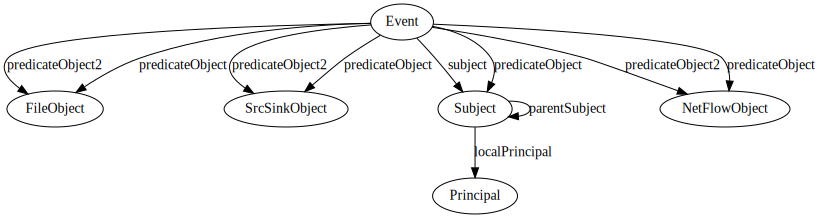

In [34]:
dot